## 자고 일어나서 개선할 포인트 (완료)
- 데이터셋을 Patient-wise하게 분할
- SGD 대신 AdamW 사용, weight_decay = 0.01
- linear evaluation 시 mlp classifier로 교체

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

ROOT = "/content/drive/MyDrive/ADV 프로젝트/data/ICBHI/ICBHI_final_database"
CHECKPOINT_PATH = "/content/drive/MyDrive/ADV 프로젝트/checkpoints"
PICKLE_PATH = "/content/drive/MyDrive/ADV 프로젝트/pickle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !wandb login

# 1. Data Step

## 1.1. Data Load

In [ ]:
import pandas as pd

text = "/content/drive/MyDrive/ADV 프로젝트/data/ICBHI/ICBHI_challenge_train_test.txt"
df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 수정 (좀 더 깔끔하게)
df.columns = ['filename', 'set']

# train, test 데이터 나누기
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

In [ ]:
print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


In [ ]:
patient_number_list = []

for filename in train_list:
    number = int(filename.split('_')[0])
    patient_number_list.append(number)

train_patient_counts = pd.Series(patient_number_list).value_counts()
train_patient_df = pd.DataFrame(data = {'Patient number': patient_number_list}, index=train_list)

In [ ]:
from torch.utils.data import Subset

# seed 고정
random.seed(42)

# 모든 환자 ID 목록
all_patient_ids = list(train_patient_counts.index)

# 130번 환자는 무조건 finetune에 할당
finetune_patients = [130]
all_patient_ids.remove(130)

# # 130번 환자 제거
# finetune_patients = []
# all_patient_ids.remove(130)

# 나머지 환자 shuffle
random.shuffle(all_patient_ids)

# 총 샘플 수
total_samples = train_patient_counts.sum()

# 현재까지 pretext에 들어간 샘플 수
pretext_patients = []
pretext_count = 0

for pid in all_patient_ids:
    new_count = train_patient_counts[pid]
    # 130번 환자를 포함한 finetune 세트가 전체의 20%가 되도록
    if pretext_count + new_count <= total_samples * 0.8:
        pretext_patients.append(pid)
        pretext_count += new_count
    else:
        finetune_patients.append(pid)

# 디버깅용 출력
print(f"[Pretext] 환자 수: {len(pretext_patients)}, 샘플 수: {pretext_count}")
print(f"[Finetune] 환자 수: {len(finetune_patients)}, 샘플 수: {train_patient_counts[finetune_patients].sum()}")

# 환자 번호 기준으로 df 분할
pretext_df = train_patient_df[train_patient_df['Patient number'].isin(pretext_patients)]
finetune_df = train_patient_df[train_patient_df['Patient number'].isin(finetune_patients)]

# 파일명 Pretext/Finetune Split
pretext_list = pretext_df.index.tolist()
finetune_iist = finetune_df.index.tolist()

[Pretext] 환자 수: 74, 샘플 수: 431
[Finetune] 환자 수: 5, 샘플 수: 108


## 1.2. Data Preprocessing

#### HyperParameter (Args)

**Data Preprocessing**  
1. *Sampling Rate*
2. *Waveform*
    - Raw Waveform
    - Wavelet
    - MFCC
    - Mel_spectogram
3. *Augmentation*  
    - SpecAug
    - RandomCrop
    - etc..
4. *Size* (5s~8s)
    - repeat
    - padding

**Training**  
1. *Pretext*  
    - epoch
    - lr
    - Batch_size
    - EMA momentum
    - weight decay
    - mlp dim
    - warmup  
3. *Finetune*  
    - epoch
    - etc ..

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [ ]:
class Args:
    # Data preprocess
    target_sr = 4000 # 4KHz
    frame_size = 1024
    hop_length = 512 # frame_size 절반
    n_mels = 128
    target_sec = 8
    # Train
    K = 512
    m = 0.999
    T = 0.07
    gpu = 0
    batch_size = 128
    workers = 4
    epochs = 300
    lr = 0.03
    momentum = 0.9
    weight_decay = 0.01
    # data = "./data_path"
    print_freq = 100
    # mlp_dim = 128
    # mlp = True
    resume = None
    schedule=[120, 160] # schedule

args = Args()

#### Dataset util (func)

- get class
- Mel Spectogram 생성 (sr, frame_size, hop_length, n_mels)
- cycle 나누기 (start-end, append list)
- cycle repeat
- spec aug

In [ ]:
# cycle 로부터 label 설정
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

In [ ]:
#  Mel Spectrogram 생성 ( sr=16KHz, frame_size=1024, hop_length=512, n_mels=128 )
def generate_mel_spectrogram(waveform, sample_rate, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels):
    if hop_length is None:
        hop_length = frame_size // 2
    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)
    return mel_db

In [ ]:
 # 사이클 데이터 Repeat
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

In [ ]:
# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):
    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

In [ ]:
# Waveform resample ( 4KHz ~ 16KHz)
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

#### DataSet

In [ ]:
import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.target_frames = target_sec * target_sr // (self.hop_length)  # target frames for mel spectrogram


        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    continue  # 잘못된 구간 스킵

                # Waveform crop(time) & Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                mel = generate_mel_spectrogram(cycle_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)
                repeat_mel = repeat_or_truncate_segment(mel, target_frames=self.target_frames) # input shape: [1, 224, 224] 맞추기 위함

                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((repeat_mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        repeat_mel, multi_label, meta_data = self.cycle_list[idx]
        return repeat_mel, multi_label, meta_data

In [ ]:
# import random
# import matplotlib.pyplot as plt
# import librosa.display

# wav_dir = ROOT
# txt_dir = ROOT

# # 1. Dataset 로드
# train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

In [ ]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

pickle로 train_dataset, test_dataset 저장

In [ ]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, 'saved_datasets_multilabel.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

저장된 train_dataset, test_dataset을 로드

In [ ]:
save_path = os.path.join(PICKLE_PATH, 'saved_datasets_multilabel.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"Total cycles: {len(train_dataset)}")

Total cycles: 4142


## 1.3. EDA

#### Data Imbalnce - Patient & Cycle


,patient_id,respiration_count
0,130,66
1,107,28
2,138,27
3,172,27
4,158,24
5,186,24
6,162,24
7,154,23
8,200,23
9,203,21


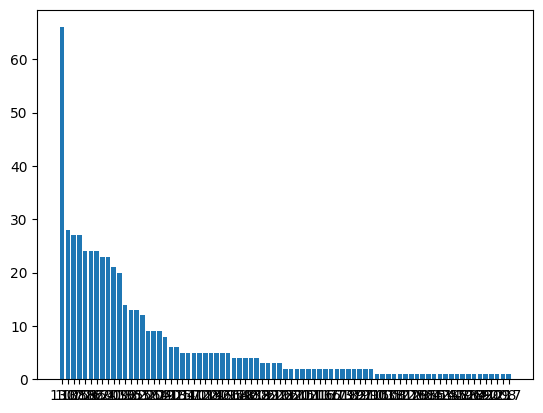

In [ ]:
# train_df에 patient_id 컬럼 직접 추가
train_df = train_df.assign(
    patient_id=train_df['filename'].apply(lambda x: x.split('_')[0])
)

# 그 후에 value_counts 사용
patient_counts = train_df['patient_id'].value_counts().sort_values(ascending=False)

# DataFrame으로 변환
patient_counts_df = pd.DataFrame({
    'patient_id': patient_counts.index,
    'respiration_count': patient_counts.values
})

# 상위 5개 확인
plt.bar(patient_counts_df['patient_id'], patient_counts_df['respiration_count'])
patient_counts_df.head(10)

,patient_id,Cycle_count
0,130,507
1,107,231
2,158,217
3,154,208
4,203,185
5,172,176
6,138,149
7,193,138
8,213,129
9,186,126


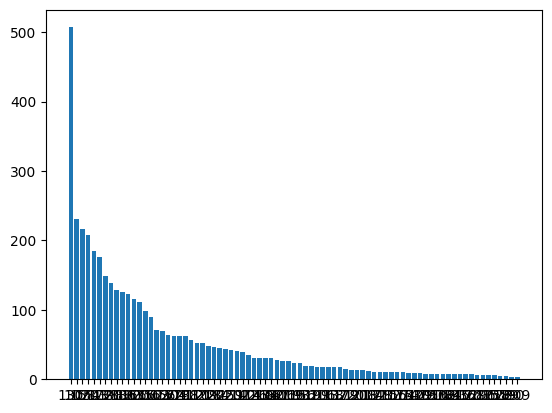

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# patient_id 추출 및 DataFrame 만들기
train_cycle = pd.DataFrame([(meta[0], meta[0].split('_')[0]) for _, _, meta in train_dataset], columns=['filename', 'patient_id'])

# patient_id별 발생 빈도수 계산
patient_counts_df = train_cycle['patient_id'].value_counts().reset_index()
patient_counts_df.columns = ['patient_id', 'Cycle_count']

# bar plot으로 시각화
plt.bar(patient_counts_df['patient_id'], patient_counts_df['Cycle_count'])
patient_counts_df.head(10)

#### Lung Sound Duration

mean duration: 2.7371561202317722 sec
Duration count per second:
0 sec: 194 cycles
1 sec: 805 cycles
2 sec: 1834 cycles
3 sec: 782 cycles
4 sec: 345 cycles
5 sec: 85 cycles
6 sec: 62 cycles
7 sec: 25 cycles
8 sec: 6 cycles
9 sec: 2 cycles
11 sec: 1 cycles
16 sec: 1 cycles


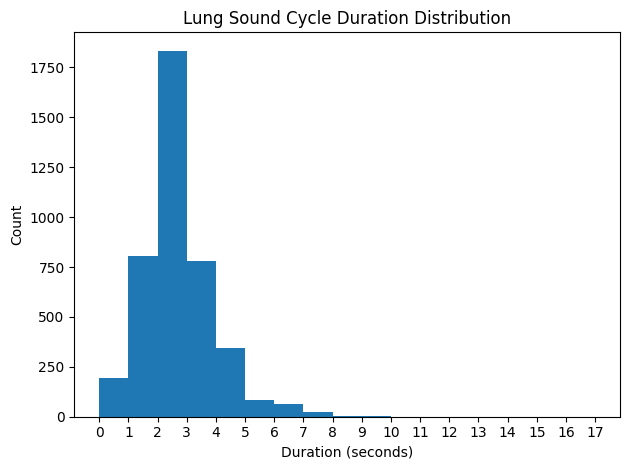

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# CycleDataset 인스턴스를 dataset이라고 가정
durations = [meta[1] for _, _, meta in train_dataset]

print(f"mean duration: {np.mean(durations)} sec")

# 히스토그램 그리기 (bin을 1초 단위로 설정)
plt.hist(durations, bins=np.arange(0, max(durations)+1, 1))

# 결과 출력
duration_counts = Counter(np.floor(durations).astype(int))  # 초 단위로 반올림 (소수점 버리기)
print("Duration count per second:")
for second in sorted(duration_counts.keys()):
    print(f"{second} sec: {duration_counts[second]} cycles")

# 그래프 설정
plt.title('Lung Sound Cycle Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.xticks(np.arange(0, max(durations)+1, 1))  # x축에 모든 초 표시
plt.tight_layout()
plt.show()

#### Mel Visualization

In [ ]:
train_dataset[1][1]

tensor([0., 0.])

In [ ]:
# import random
# import matplotlib.pyplot as plt

# # 저장할 디렉터리
# save_root = "/content/drive/MyDrive/ADV 프로젝트/Pictures"
# os.makedirs(save_root, exist_ok=True)

# # label별로 인덱스를 그룹화
# label_to_indices = {'Normal': [], 'Crackle': [], 'Wheeze': [], 'Both': []}
# multi_label_list = set([torch.tensor([0., 0.]), torch.tensor([1., 0.]), torch.tensor([0., 1.]), torch.tensor([1., 1.])])

# for idx in range(len(train_dataset)):
#     _, multi_label, _ = train_dataset[idx]

#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label = 'Normal'
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label = 'Crackle'
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label = 'Wheeze'
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label = 'Both'

#     label_to_indices[label].append(idx)

# # 각 label에서 50개씩 랜덤하게 샘플을 뽑아서 시각화
# n_labels = len(label_to_indices)
# samples_per_label = 50  # 각 label에서 50개씩 샘플 선택

# for label, indices in label_to_indices.items():
#     # 저장 경로 생성
#     label_dir = os.path.join(save_root, f"label_{label}")
#     os.makedirs(label_dir, exist_ok=True)

#     # 샘플 선택
#     sample_indices = random.sample(indices, samples_per_label)

#     for i, sample_idx in enumerate(sample_indices):
#         mel, multi_label, meta = train_dataset[sample_idx]

#         if torch.equal(multi_label, torch.tensor([0., 0.])):
#             label = 'Normal'
#         elif torch.equal(multi_label, torch.tensor([1., 0.])):
#             label = 'Crackle'
#         elif torch.equal(multi_label, torch.tensor([0., 1.])):
#             label = 'Wheeze'
#         elif torch.equal(multi_label, torch.tensor([1., 1.])):
#             label = 'Both'

#         plt.figure(figsize=(8, 4))
#         plt.imshow(mel.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
#         plt.title(f"[file] {meta[0]} / [Cycle] {sample_idx} - [Label: {label}]")
#         plt.colorbar(format='%+2.0f dB')
#         plt.tight_layout()

#         # 저장 경로
#         filename = f"{i:03d}_{meta[0]}.png"
#         save_path = os.path.join(label_dir, filename)
#         plt.savefig(save_path)
#         plt.close()

## 1.4. Pretext-Fine Split

### DataLoader

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)

pretext_idx = []
finetune_idx = []

for i in range(len(train_dataset)):
    filename = train_dataset[i][2][0]

    if filename in pretext_list:
        pretext_idx.append(i)
    elif filename in finetune_iist:
        finetune_idx.append(i)

random.shuffle(pretext_idx)
random.shuffle(finetune_idx)

print(f"Pretext set size: {len(pretext_idx)}, Finetune set size: {len(finetune_idx)}")

Pretext set size: 3194, Finetune set size: 948


In [ ]:
# Dataset 생성 (Subset)
pretext_dataset = Subset(train_dataset, pretext_idx)
finetune_dataset = Subset(train_dataset, finetune_idx)

# DataLoader 생성
pretext_loader = DataLoader(
    pretext_dataset,
    batch_size=args.batch_size,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    shuffle=False     # 위에서 임의의 셔플을 미리 했음
)

finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=args.batch_size,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

#### legacy

- Pretext, Fine = 8:2 비율  
- StratifiedShuffle - 클래스 비율 유지
- WeightedRandomSampler 통한 DataLoader 구성

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# from torch.utils.data import Subset

# # labels
# labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# # Stratified Split
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# for pretext_idx, finetune_idx in sss.split(torch.zeros(len(labels)), labels):
#     print(f"Pretext set size: {len(pretext_idx)}, Finetune set size: {len(finetune_idx)}")

# # Subset - DataLoader Input
# pretext_dataset = Subset(train_dataset, pretext_idx)
# finetune_dataset = Subset(train_dataset, finetune_idx)

In [ ]:
# # Pretext DataLoader
# pre_labels = torch.stack([train_dataset[idx][1] for idx in pretext_idx])
# pre_labels_class = (
#     pre_labels[:, 0].long() * 1 +  # crackle bit → *1
#     pre_labels[:, 1].long() * 2    # wheeze bit  → *2
# )  # [N] shape, values in {0, 1, 2, 3}
# pre_class_counts = torch.bincount(pre_labels_class)
# pre_class_weights = 1.0 / pre_class_counts.float()
# pre_sample_weights = pre_class_weights[pre_labels_class]

# pre_sampler = WeightedRandomSampler(
#     weights=pre_sample_weights,
#     num_samples=len(pre_sample_weights),
#     replacement=True
# )

# pretext_loader = DataLoader(
#     pretext_dataset,
#     batch_size=args.batch_size,
#     sampler=pre_sampler,
#     num_workers=4,
#     drop_last=True,
#     pin_memory=True
# )

# # finetune DataLoader
# fin_labels = torch.stack([train_dataset[idx][1] for idx in finetune_idx])
# fin_labels_class = (
#     fin_labels[:, 0].long() * 1 +  # crackle bit → *1
#     fin_labels[:, 1].long() * 2    # wheeze bit  → *2
# )  # [N] shape, values in {0, 1, 2, 3}
# fin_class_counts = torch.bincount(fin_labels_class)
# fin_class_weights = 1.0 / fin_class_counts.float()
# fin_sample_weights = fin_class_weights[fin_labels_class]

# fin_sampler = WeightedRandomSampler(
#     weights=fin_sample_weights,
#     num_samples=len(fin_sample_weights),
#     replacement=True
# )

# finetune_loader = DataLoader(
#     finetune_dataset,
#     batch_size=args.batch_size,
#     sampler=fin_sampler,
#     num_workers=4,
#     drop_last=True,
#     pin_memory=True
# )

#### label 분포

In [ ]:
from collections import Counter

# label
labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# pretext와 finetune 데이터셋의 라벨 분포 출력
pretext_labels = labels[pretext_idx]
pretext_labels_class = (
    pretext_labels[:, 0].long() * 1 +  # crackle bit → *1
    pretext_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}
finetune_labels = labels[finetune_idx]
finetune_labels_class = (
    finetune_labels[:, 0].long() * 1 +  # crackle bit → *1
    finetune_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"[Pretext Dataset] Total: {len(pretext_labels_class)}")
print("Pretext label distribution:", Counter(pretext_labels_class.tolist()))
print(f"\n[Finetune Dataset] Total: {len(finetune_labels_class)}")
print("Finetune label distribution:", Counter(finetune_labels_class.tolist()))

[Pretext Dataset] Total: 3194
Pretext label distribution: Counter({0: 1820, 1: 815, 2: 363, 3: 196})

[Finetune Dataset] Total: 948
Finetune label distribution: Counter({1: 400, 0: 243, 3: 167, 2: 138})


# 2. Modeling Step

## 2.1 Pre-trained ResNet50

In [ ]:
# # from https://github.com/raymin0223/patch-mix_contrastive_learning/blob/main/models/resnet.py

# class ResNet50(torchvision.models.resnet.ResNet):
#     def __init__(self, track_bn=True, num_classes):
#         def norm_layer(*args, **kwargs):
#             return nn.BatchNorm2d(*args, **kwargs, track_running_stats=track_bn)
#         super().__init__(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], norm_layer=norm_layer)
#         del self.fc
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.final_feat_dim = 2048
#         self.num_classes = num_classes

#     def load_sl_official_weights(self, progress=True):
#         state_dict = load_state_dict_from_url(torchvision.models.resnet.model_urls['resnet50'],
#                                               progress=progress)

#         del state_dict['conv1.weight']
#         missing, unexpected = self.load_state_dict(state_dict, strict=False)
#         # if len(missing) > 0:
#             # raise AssertionError('Model code may be incorrect')

#     def _forward_impl(self, x: Tensor) -> Tensor:
#         # See note [TorchScript super()]
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         # x = self.fc(x)

#         return x

def backbone_resnet():
    # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
    resnet = models.resnet50(pretrained=False)

    # 2. 첫 번째 conv 레이어를 1채널용으로 수정
    resnet.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )

    # 먼저 fc 제거
    resnet.fc = nn.Identity()

    # 3. ImageNet 가중치 로드 (conv1 제외)
    state_dict = load_state_dict_from_url(
        'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        progress=True
    )
    if 'conv1.weight' in state_dict:
        del state_dict['conv1.weight']
    resnet.load_state_dict(state_dict, strict=False)

    # # 4. MLP head 설정
    # dim_mlp = 2048
    # if mlp:  # MoCo v2의 MLP head
    #     resnet.fc = nn.Sequential(
    #         nn.Linear(dim_mlp, dim_mlp),
    #         nn.GELU(),
    #         nn.Linear(dim_mlp, dim)   # (2048, 128)
    #     )
    # else:  # 단순 projection head
    #     resnet.fc = nn.Linear(dim_mlp, dim)

    # # 5. BatchNorm 설정
    # for m in resnet.modules():
    #     if isinstance(m, nn.BatchNorm2d):
    #         m.requires_grad = True
    #         m.track_running_stats = True
    #         m.momentum = 0.1

    return resnet

In [ ]:
# import torchvision.models as models
# from torchsummary import summary
# import torch.nn as nn

# def resnet(num_classes=128):
#     # 1. 기본 resnet50 불러오기
#     resnet = models.resnet50(weights="IMAGENET1K_V2")# Resnet ImageNet pretrained

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정 (기존: Conv2d(3, 64, ...))
#     resnet.conv1 = nn.Conv2d(
#         in_channels=1,       # 오디오나 흑백 이미지
#         out_channels=64,
#         kernel_size=7,
#         stride=2,
#         padding=3,
#         bias=False
#     )

#     ## 마지막 feature 는 (batch, channels, 1, 1) 이 나옴.

#     # 3. MoCo(MLP=True) -> 마지막 fc 레이어는 Moco Class 내부에서 MLP 로 바꿔줌
#     resnet.fc = nn.Linear(2048, num_classes)

#     return resnet

In [ ]:
# # summary 함수 사용: (채널, 높이, 너비) 크기를 지정
# summary(backbone_resnet().to(device), input_size=(1, 224, 64))

## 2.2 Moco (MLS)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# K: queue_g의 크기
# dim_enc: projector 통과 전, g1,g2 벡터의 차원
# dim_prj: projector 통과 후, z1,z2 벡터의 차원
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim_prj=128, K=512, m=0.999, T=0.07, top_k=10, lambda_bce=0.5):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T
        self.top_k = top_k
        self.lambda_bce = lambda_bce

        self.encoder_q = base_encoder()
        self.encoder_k = base_encoder()

        dim_enc = 2048
        self.proj_head_q = nn.Sequential(
            nn.Linear(dim_enc, dim_enc),
            nn.BatchNorm1d(dim_enc),
            nn.GELU(),
            nn.Linear(dim_enc, dim_prj)
        )
        self.proj_head_k = nn.Sequential(
            nn.Linear(dim_enc, dim_enc),
            nn.BatchNorm1d(dim_enc),
            nn.GELU(),
            nn.Linear(dim_enc, dim_prj)
        )

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue_g", F.normalize(torch.randn(dim_enc, K), dim=0))      # g2를 정규화한 후 열 단위로 Qg에 저장
        self.register_buffer("queue_z", F.normalize(torch.randn(dim_prj, K), dim=0))      # z2를 정규화한 후 열 단위로 Qz에 저장
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))               # 현재 queue에 새로 쓸 위치(인덱스)를 추적하는 포인터 역할

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, g2, z2):
        batch_size = g2.shape[0]
        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0
        # self.queue_g[:, ptr:ptr + batch_size] = g2.T.detach()[:, :self.queue_g.shape[1] - ptr]  # Update only available space
        # self.queue_z[:, ptr:ptr + batch_size] = z2.T.detach()[:, :self.queue_z.shape[1] - ptr]  # Update only available space
        self.queue_g[:, ptr:ptr+batch_size] = g2.T.detach()
        self.queue_z[:, ptr:ptr+batch_size] = z2.T.detach()
        self.queue_ptr[0] = (ptr + batch_size) % self.K

    def forward(self, im_q, im_k, epoch=None, warmup_epochs=10):
        # encoder_q → g1 (feature)
        g1 = F.normalize(self.encoder_q(im_q), dim=1)  # shape: [B, 2048]

        # projection head → z1
        z1 = F.normalize(self.proj_head_q(g1), dim=1)  # shape: [B, 128]

        # encoder k
        with torch.no_grad():
            self._momentum_update_key_encoder()
            g2 = F.normalize(self.encoder_k(im_k), dim=1)
            z2 = F.normalize(self.proj_head_k(g2), dim=1)

        # top-k mining
        sim_g = torch.matmul(g1, self.queue_g.clone().detach())  # [N, K]
        topk_idx = torch.topk(sim_g, self.top_k, dim=1).indices
        y = torch.zeros_like(sim_g)
        y.scatter_(1, topk_idx, 1.0)

        # logits from z1 · Qz
        sim_z = torch.matmul(z1, self.queue_z.clone().detach())
        bce_loss = F.binary_cross_entropy_with_logits(sim_z / self.T, y)

        # InfoNCE loss
        l_pos = torch.sum(z1 * z2, dim=1, keepdim=True)
        l_neg = torch.matmul(z1, self.queue_z.clone().detach())
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(logits.device)
        info_nce_loss = F.cross_entropy(logits, labels)

        # Total loss (with optional warmup)
        if epoch is not None and epoch < warmup_epochs:
            loss = info_nce_loss
        else:
            loss = info_nce_loss + self.lambda_bce * bce_loss

        self._dequeue_and_enqueue(g2, z2)

        return loss, logits, labels

#### Legacy

In [ ]:
# import torch
# import torch.nn as nn

# class MoCo(nn.Module):
#     """
#     Build a MoCo model with: a query encoder, a key encoder, and a queue
#     https://arxiv.org/abs/1911.05722
#     """

#     def __init__(self, base_encoder, dim=args.mlp_dim, K=args.K, m=args.m, T=args.T, mlp=args.mlp):
#         """
#         dim: feature dimension (default: 128)
#         K: queue size; number of negative keys (default: 8192) # original=65536
#         m: moco momentum of updating key encoder (default: 0.999)
#         T: softmax temperature (default: 0.07)
#         mlp: if True, use MLP head (default: True)
#         """
#         super(MoCo, self).__init__()

#         self.K = K
#         self.m = m
#         self.T = T

#         # create the encoders
#         # num_classes is the output fc dimension
#         self.encoder_q = base_encoder(dim=args.mlp_dim, mlp=args.mlp)
#         self.encoder_k = base_encoder(dim=args.mlp_dim, mlp=args.mlp)

#         if mlp:  # hack: brute-force replacement
#             dim_mlp = self.encoder_q.fc.weight.shape[1]
#             self.encoder_q.fc = nn.Sequential(
#                 nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc
#             )
#             self.encoder_k.fc = nn.Sequential(
#                 nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc
#             )

#         for param_q, param_k in zip(
#             self.encoder_q.parameters(), self.encoder_k.parameters()
#         ):
#             param_k.data.copy_(param_q.data)  # initialize
#             param_k.requires_grad = False  # not update by gradient

#         # create the queue
#         self.register_buffer("queue", torch.randn(dim, K))
#         self.queue = nn.functional.normalize(self.queue, dim=0)

#         self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

#     @torch.no_grad()
#     def _momentum_update_key_encoder(self):
#         """
#         Momentum update of the key encoder
#         """
#         for param_q, param_k in zip(
#             self.encoder_q.parameters(), self.encoder_k.parameters()
#         ):
#             param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

#     @torch.no_grad()
#     def _dequeue_and_enqueue(self, keys):
#         # gather keys before updating queue
#         keys = keys

#         batch_size = keys.shape[0]

#         ptr = int(self.queue_ptr)
#         assert self.K % batch_size == 0  # for simplicity

#         # replace the keys at ptr (dequeue and enqueue)
#         self.queue[:, ptr : ptr + batch_size] = keys.T
#         ptr = (ptr + batch_size) % self.K  # move pointer

#         self.queue_ptr[0] = ptr

#     def forward(self, im_q, im_k):
#         """
#         Input:
#             im_q: a batch of query images
#             im_k: a batch of key images
#         Output:
#             logits, targets
#         """

#         # compute query features
#         q = self.encoder_q(im_q)  # queries: NxC
#         q = nn.functional.normalize(q, dim=1)

#         # compute key features
#         with torch.no_grad():  # no gradient to keys
#             self._momentum_update_key_encoder()  # update the key encoder
#             k = self.encoder_k(im_k)  # keys: NxC
#             k = nn.functional.normalize(k, dim=1)

#         # compute logits
#         # Einstein sum is more intuitive
#         # positive logits: Nx1
#         l_pos = torch.einsum("nc,nc->n", [q, k]).unsqueeze(-1) # [N, 1]
#         # negative logits: NxK
#         l_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()])  # [N,dim] * [dim,K] = [N,K]


#         # logits: Nx(1+K)
#         logits = torch.cat([l_pos, l_neg], dim=1) # [N, 1+K]

#         # apply temperature
#         logits /= self.T

#         # labels: positive key indicators
#         labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

#         # dequeue and enqueue
#         self._dequeue_and_enqueue(k)

#         return logits, labels

# 3. Training Step

In [ ]:
next(iter(pretext_loader))[0][0].shape

torch.Size([1, 128, 62])

#### Aug

In [ ]:
def aug(repeat_mel):
    aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
    return aug1, aug2, aug3

#### Visualization


Original dB Spectrogram shape: torch.Size([1, 128, 62])


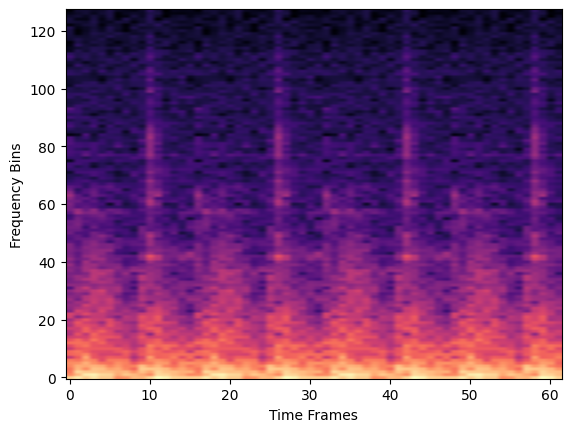

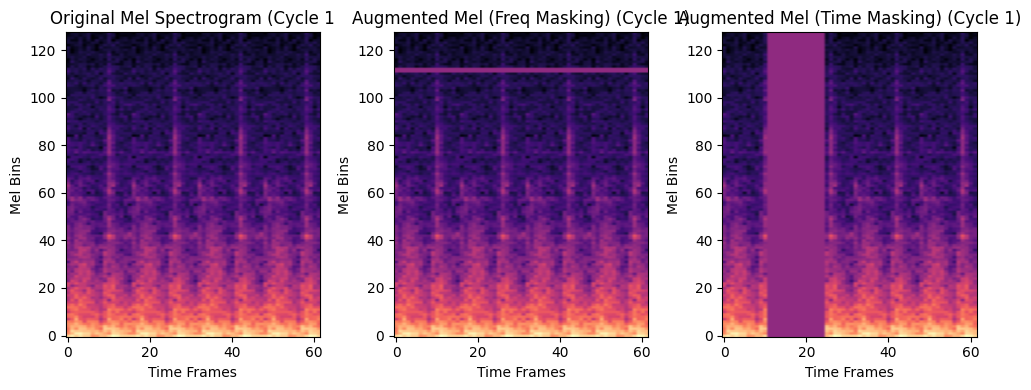

Original dB Spectrogram shape: torch.Size([1, 128, 62])


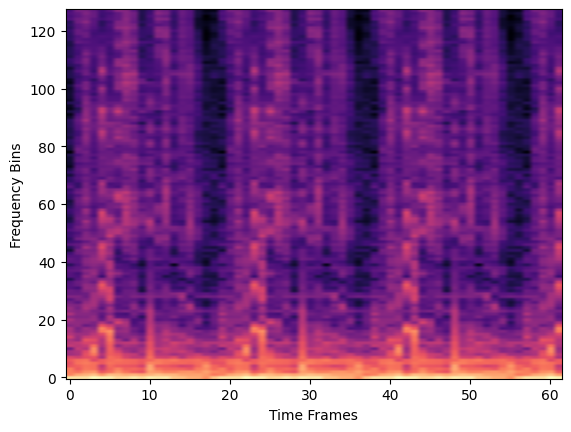

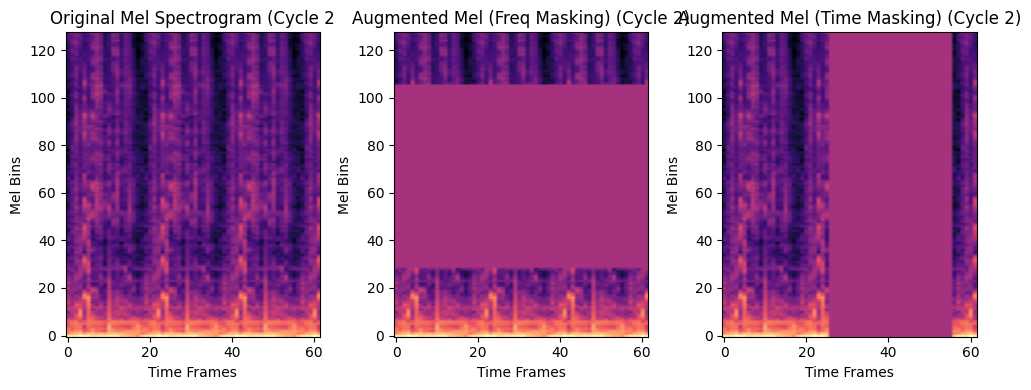

Original dB Spectrogram shape: torch.Size([1, 128, 62])


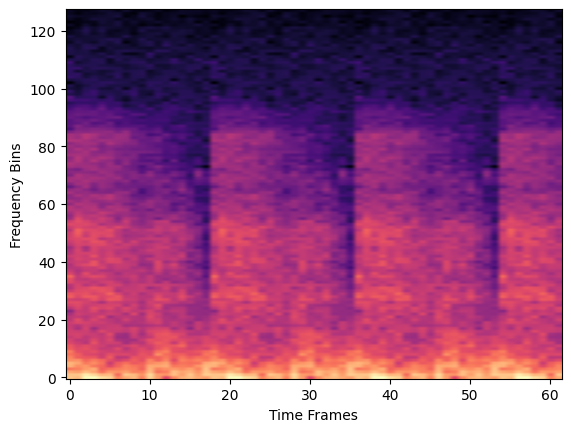

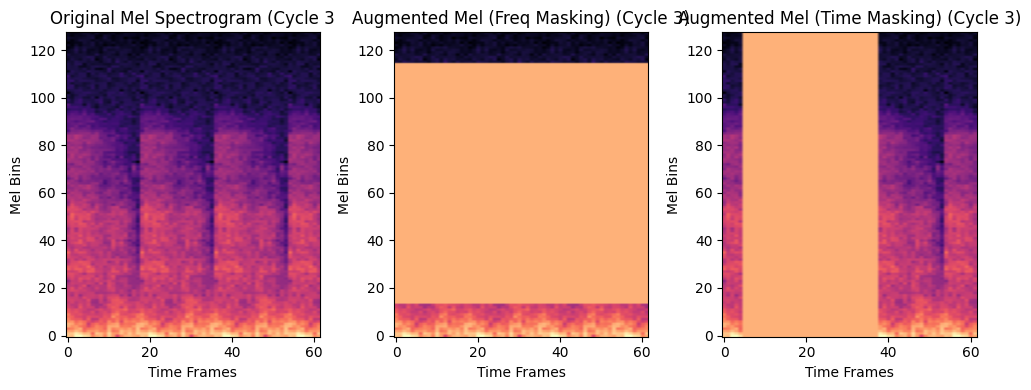

In [ ]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from itertools import islice

n_list = 3

# 🔹 각 파일별로 cycle segments 시각화
for i, cycle_data in enumerate(islice(pretext_dataset, n_list)):
    target_frame = 62
    cycle, label, _ = cycle_data

    # 1. segment repeat = 🔹 전체 원본 db 스펙트로그램 (크게 출력)
    origin_db = cycle  # 첫 번째 세그먼트에서 전체 db 스펙트로그램 사용
    print(f"Original dB Spectrogram shape: {origin_db.shape}")  # 🔹 데이터 shape 확인


    # 🔹 원본 dB Spectrogram을 크게 시각화
    fig, main_ax = plt.subplots()
    main_ax.imshow(origin_db.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    # main_ax.set_title(f"Original dB Spectrogram - {filename}")
    main_ax.set_xlabel("Time Frames")
    main_ax.set_ylabel("Frequency Bins")
    plt.show()

    # 2.세그먼트 개수에 맞게 서브플롯 생성 (repeat + 두 가지 Augment 버전)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4)) # plt.subplots(행, 열, figsize)

    ax1, ax2, ax3 = axes

    repeat = repeat_or_truncate_segment(cycle, target_frame)
    augmented_spec1, augmented_spec2, augmented_spec3 = apply_spec_augment(repeat)

    # 🔹 원본 repeaet Mel Spectrogram 시각화
    ax1.imshow(repeat.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    ax1.set_title(f"Original Mel Spectrogram (Cycle {i+1}")
    ax1.set_xlabel("Time Frames")
    ax1.set_ylabel("Mel Bins")

    # 🔹 주파수 마스킹이 적용된 Mel Spectrogram 시각화
    ax2.imshow(augmented_spec1.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    ax2.set_title(f"Augmented Mel (Freq Masking) (Cycle {i+1})")
    ax2.set_xlabel("Time Frames")
    ax2.set_ylabel("Mel Bins")

    # 🔹 시간 마스킹이 적용된 Mel Spectrogram 시각화
    ax3.imshow(augmented_spec2.squeeze(0).numpy(), aspect='auto', origin='lower', cmap='magma')
    ax3.set_title(f"Augmented Mel (Time Masking) (Cycle {i+1})")
    ax3.set_xlabel("Time Frames")
    ax3.set_ylabel("Mel Bins")

    plt.tight_layout()
    plt.show()


#### Utils

In [ ]:
def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

#### Train

In [ ]:
project_name = f'Moco_MLS_PT_ICBHI_128batch_{get_timestamp()}'

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="SHS_ICBHI_MLS", # 프로젝트 이름
    name=f"{project_name}",  # 실험 이름
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay
    }
)

# 1. MoCo 모델 생성
model = MoCo(base_encoder = backbone_resnet).cuda()

# 2. Optimizer
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     args.lr,
#     momentum=args.momentum,
#     weight_decay=args.weight_decay,
# )
optimizer = torch.optim.AdamW(model.parameters(), args.lr, weight_decay=args.weight_decay)

# 3. Cosine Scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=args.epochs,
    eta_min=1e-6
)

# Best loss 초기화
best_loss = float('inf')
best_epoch = -1

for epoch in range(args.epochs):
    # ===============================
    # Training
    # ===============================
    model.train()
    total_train_loss = 0.0

    for i, (repeat_mel, label, _) in enumerate(pretext_loader): # label 여기선 사용 X
        im_q, im_k, _ = aug(repeat_mel)
        im_q = im_q.cuda(device=args.gpu, non_blocking=True)
        im_k = im_k.cuda(device=args.gpu, non_blocking=True)

        optimizer.zero_grad()
        loss, output, target = model(im_q=im_q, im_k=im_k)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(pretext_loader)
    print(f"Epoch {epoch} | Avg Train Loss: {avg_train_loss:.4f}")

    # =====================================
    # Scheduler
    # =====================================
    scheduler.step()

    # =====================================
    # 3. Logging with wandb
    # =====================================
    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "lr": current_lr
    })

    # =====================================
    # Checkpoint (Every 100 epochs)
    # =====================================
    if (epoch + 1) % 100 == 0:
        ckpt_path = CHECKPOINT_PATH + f"{project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {ckpt_path}")

    # ===============================
    # Save Best Checkpoint
    # ===============================
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_epoch = epoch
        best_ckpt_path = CHECKPOINT_PATH + f"{project_name}_best_checkpoint.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")

wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

Epoch 0 | Avg Train Loss: 7.2598
=> Saved best checkpoint (epoch: 0, loss: 7.2598)
Epoch 1 | Avg Train Loss: 6.7924
=> Saved best checkpoint (epoch: 1, loss: 6.7924)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2 | Avg Train Loss: 6.3982
=> Saved best checkpoint (epoch: 2, loss: 6.3982)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3 | Avg Train Loss: 6.2556
=> Saved best checkpoint (epoch: 3, loss: 6.2556)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4 | Avg Train Loss: 5.9418
=> Saved best checkpoint (epoch: 4, loss: 5.9418)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5 | Avg Train Loss: 5.6086
=> Saved best checkpoint (epoch: 5, loss: 5.6086)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6 | Avg Train Loss: 5.4496
=> Saved best checkpoint (epoch: 6, loss: 5.4496)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7 | Avg Train Loss: 5.4849


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8 | Avg Train Loss: 5.1145
=> Saved best checkpoint (epoch: 8, loss: 5.1145)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9 | Avg Train Loss: 5.0614
=> Saved best checkpoint (epoch: 9, loss: 5.0614)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10 | Avg Train Loss: 4.8635
=> Saved best checkpoint (epoch: 10, loss: 4.8635)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11 | Avg Train Loss: 4.7584
=> Saved best checkpoint (epoch: 11, loss: 4.7584)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12 | Avg Train Loss: 4.7799


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13 | Avg Train Loss: 4.7520
=> Saved best checkpoint (epoch: 13, loss: 4.7520)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14 | Avg Train Loss: 4.4286
=> Saved best checkpoint (epoch: 14, loss: 4.4286)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15 | Avg Train Loss: 4.6233


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16 | Avg Train Loss: 4.5300
Epoch 17 | Avg Train Loss: 4.4145
=> Saved best checkpoint (epoch: 17, loss: 4.4145)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18 | Avg Train Loss: 4.3668
=> Saved best checkpoint (epoch: 18, loss: 4.3668)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19 | Avg Train Loss: 4.2104
=> Saved best checkpoint (epoch: 19, loss: 4.2104)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20 | Avg Train Loss: 4.2309


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21 | Avg Train Loss: 4.1575
=> Saved best checkpoint (epoch: 21, loss: 4.1575)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22 | Avg Train Loss: 4.1740


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23 | Avg Train Loss: 4.2798


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24 | Avg Train Loss: 3.9135
=> Saved best checkpoint (epoch: 24, loss: 3.9135)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25 | Avg Train Loss: 3.9364


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26 | Avg Train Loss: 4.0135


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27 | Avg Train Loss: 4.0570


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28 | Avg Train Loss: 4.0806


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29 | Avg Train Loss: 4.0272


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30 | Avg Train Loss: 3.9139
Epoch 31 | Avg Train Loss: 3.9105
=> Saved best checkpoint (epoch: 31, loss: 3.9105)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32 | Avg Train Loss: 3.9151


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33 | Avg Train Loss: 3.8810
=> Saved best checkpoint (epoch: 33, loss: 3.8810)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34 | Avg Train Loss: 3.7872
=> Saved best checkpoint (epoch: 34, loss: 3.7872)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35 | Avg Train Loss: 3.6852
=> Saved best checkpoint (epoch: 35, loss: 3.6852)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36 | Avg Train Loss: 3.5933
=> Saved best checkpoint (epoch: 36, loss: 3.5933)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37 | Avg Train Loss: 3.8608


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38 | Avg Train Loss: 3.6310


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39 | Avg Train Loss: 3.6628


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40 | Avg Train Loss: 3.7532


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41 | Avg Train Loss: 3.9519


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42 | Avg Train Loss: 3.6884


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43 | Avg Train Loss: 3.5640
=> Saved best checkpoint (epoch: 43, loss: 3.5640)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44 | Avg Train Loss: 3.5838


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45 | Avg Train Loss: 3.5712


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46 | Avg Train Loss: 3.4526
=> Saved best checkpoint (epoch: 46, loss: 3.4526)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47 | Avg Train Loss: 3.8783


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48 | Avg Train Loss: 3.6371
Epoch 49 | Avg Train Loss: 3.8991
Epoch 50 | Avg Train Loss: 3.5191
Epoch 51 | Avg Train Loss: 3.6725
Epoch 52 | Avg Train Loss: 3.4082
=> Saved best checkpoint (epoch: 52, loss: 3.4082)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53 | Avg Train Loss: 3.4260


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54 | Avg Train Loss: 3.4483


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55 | Avg Train Loss: 3.4147


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56 | Avg Train Loss: 3.4962


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57 | Avg Train Loss: 3.3112
=> Saved best checkpoint (epoch: 57, loss: 3.3112)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58 | Avg Train Loss: 3.5051


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59 | Avg Train Loss: 3.5477


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60 | Avg Train Loss: 3.3056
=> Saved best checkpoint (epoch: 60, loss: 3.3056)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 61 | Avg Train Loss: 3.2265
=> Saved best checkpoint (epoch: 61, loss: 3.2265)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 62 | Avg Train Loss: 3.2841


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 63 | Avg Train Loss: 3.1663
=> Saved best checkpoint (epoch: 63, loss: 3.1663)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 64 | Avg Train Loss: 3.1679


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 65 | Avg Train Loss: 3.1522
=> Saved best checkpoint (epoch: 65, loss: 3.1522)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 66 | Avg Train Loss: 3.3974


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 67 | Avg Train Loss: 3.2846


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 68 | Avg Train Loss: 2.9419
=> Saved best checkpoint (epoch: 68, loss: 2.9419)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 69 | Avg Train Loss: 2.9238
=> Saved best checkpoint (epoch: 69, loss: 2.9238)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 70 | Avg Train Loss: 3.1903


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 71 | Avg Train Loss: 3.3048


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 72 | Avg Train Loss: 3.0969


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 73 | Avg Train Loss: 3.1720


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 74 | Avg Train Loss: 3.1979


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 75 | Avg Train Loss: 3.1120


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 76 | Avg Train Loss: 3.2928


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 77 | Avg Train Loss: 3.0325


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 78 | Avg Train Loss: 3.0057


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 79 | Avg Train Loss: 3.0695
Epoch 80 | Avg Train Loss: 3.0898


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 81 | Avg Train Loss: 2.9614


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 82 | Avg Train Loss: 3.1522


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 83 | Avg Train Loss: 2.8176
=> Saved best checkpoint (epoch: 83, loss: 2.8176)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 84 | Avg Train Loss: 2.8997
Epoch 85 | Avg Train Loss: 2.9359


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 86 | Avg Train Loss: 3.0049


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 87 | Avg Train Loss: 3.0172


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 88 | Avg Train Loss: 2.8437
Epoch 89 | Avg Train Loss: 2.6333
=> Saved best checkpoint (epoch: 89, loss: 2.6333)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 90 | Avg Train Loss: 3.0189


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 91 | Avg Train Loss: 2.7802


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 92 | Avg Train Loss: 2.8349


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 93 | Avg Train Loss: 3.1345


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 94 | Avg Train Loss: 2.6752


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 95 | Avg Train Loss: 2.7396
Epoch 96 | Avg Train Loss: 2.9179


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 97 | Avg Train Loss: 2.6408


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 98 | Avg Train Loss: 2.7645


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 99 | Avg Train Loss: 2.8652
💾 Saved checkpoint to /content/drive/MyDrive/ADV 프로젝트/checkpointsMoco_MLS_PT_ICBHI_128batch_2505301544_099.pth.tar


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 100 | Avg Train Loss: 2.7585
Epoch 101 | Avg Train Loss: 2.7636


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 102 | Avg Train Loss: 2.8569


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 103 | Avg Train Loss: 2.7494
Epoch 104 | Avg Train Loss: 2.6758


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 105 | Avg Train Loss: 2.6789


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 106 | Avg Train Loss: 2.5896
=> Saved best checkpoint (epoch: 106, loss: 2.5896)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 107 | Avg Train Loss: 2.8894
Epoch 108 | Avg Train Loss: 2.2166
=> Saved best checkpoint (epoch: 108, loss: 2.2166)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 109 | Avg Train Loss: 2.6342


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 110 | Avg Train Loss: 2.6380


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 111 | Avg Train Loss: 2.6905
Epoch 112 | Avg Train Loss: 2.6304


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 113 | Avg Train Loss: 2.4352


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 114 | Avg Train Loss: 2.3419


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 115 | Avg Train Loss: 2.2341


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 116 | Avg Train Loss: 2.7689
Epoch 117 | Avg Train Loss: 2.5820


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 118 | Avg Train Loss: 2.7878
Epoch 119 | Avg Train Loss: 2.5434
Epoch 120 | Avg Train Loss: 2.6603


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 121 | Avg Train Loss: 2.6605


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 122 | Avg Train Loss: 2.3860
Epoch 123 | Avg Train Loss: 2.3931


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 124 | Avg Train Loss: 2.4170


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 125 | Avg Train Loss: 2.6795


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 126 | Avg Train Loss: 2.4121


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 127 | Avg Train Loss: 2.5392


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 128 | Avg Train Loss: 2.5010


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 129 | Avg Train Loss: 2.3960
Epoch 130 | Avg Train Loss: 2.1356
=> Saved best checkpoint (epoch: 130, loss: 2.1356)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 131 | Avg Train Loss: 2.3371
Epoch 132 | Avg Train Loss: 2.5072


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 133 | Avg Train Loss: 2.5676


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 134 | Avg Train Loss: 2.3871
Epoch 135 | Avg Train Loss: 2.5578
Epoch 136 | Avg Train Loss: 2.3978
Epoch 137 | Avg Train Loss: 2.3136
Epoch 138 | Avg Train Loss: 2.3939


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 139 | Avg Train Loss: 2.4244


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 140 | Avg Train Loss: 2.4519


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 141 | Avg Train Loss: 2.3079


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 142 | Avg Train Loss: 2.3261


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 143 | Avg Train Loss: 2.3289


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 144 | Avg Train Loss: 2.5046


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 145 | Avg Train Loss: 2.4137


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 146 | Avg Train Loss: 2.3406


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 147 | Avg Train Loss: 2.1724


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 148 | Avg Train Loss: 2.4754


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 149 | Avg Train Loss: 2.0383
=> Saved best checkpoint (epoch: 149, loss: 2.0383)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 150 | Avg Train Loss: 2.2054


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 151 | Avg Train Loss: 2.5048
Epoch 152 | Avg Train Loss: 2.4599


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 153 | Avg Train Loss: 2.3719


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 154 | Avg Train Loss: 2.2911


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 155 | Avg Train Loss: 2.3629


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 156 | Avg Train Loss: 2.0667


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 157 | Avg Train Loss: 2.4008


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 158 | Avg Train Loss: 2.1652


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 159 | Avg Train Loss: 2.5209
Epoch 160 | Avg Train Loss: 2.4562


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 161 | Avg Train Loss: 2.0492


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 162 | Avg Train Loss: 2.4633


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 163 | Avg Train Loss: 2.4036


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 164 | Avg Train Loss: 2.4808


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 165 | Avg Train Loss: 2.2413


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 166 | Avg Train Loss: 1.9985
=> Saved best checkpoint (epoch: 166, loss: 1.9985)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 167 | Avg Train Loss: 2.2995
Epoch 168 | Avg Train Loss: 2.2382


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 169 | Avg Train Loss: 2.3269
Epoch 170 | Avg Train Loss: 2.1244


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 171 | Avg Train Loss: 2.0478


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 172 | Avg Train Loss: 2.0675
Epoch 173 | Avg Train Loss: 2.0789


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 174 | Avg Train Loss: 2.3419


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 175 | Avg Train Loss: 1.8999
=> Saved best checkpoint (epoch: 175, loss: 1.8999)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 176 | Avg Train Loss: 1.9489


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 177 | Avg Train Loss: 2.0149


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 178 | Avg Train Loss: 2.2467
Epoch 179 | Avg Train Loss: 1.8654
=> Saved best checkpoint (epoch: 179, loss: 1.8654)
Epoch 180 | Avg Train Loss: 2.1654


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 181 | Avg Train Loss: 1.7808
=> Saved best checkpoint (epoch: 181, loss: 1.7808)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 182 | Avg Train Loss: 2.0401


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 183 | Avg Train Loss: 2.1930


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 184 | Avg Train Loss: 2.3709


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 185 | Avg Train Loss: 1.9126


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 186 | Avg Train Loss: 2.1609


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 187 | Avg Train Loss: 1.8154


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 188 | Avg Train Loss: 2.2789


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 189 | Avg Train Loss: 1.9769


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 190 | Avg Train Loss: 1.9381
Epoch 191 | Avg Train Loss: 2.0523


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 192 | Avg Train Loss: 2.0284
Epoch 193 | Avg Train Loss: 2.1359


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 194 | Avg Train Loss: 2.1158
Epoch 195 | Avg Train Loss: 1.9484
Epoch 196 | Avg Train Loss: 2.0197


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 197 | Avg Train Loss: 2.0336


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 198 | Avg Train Loss: 2.0184


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 199 | Avg Train Loss: 2.1314
💾 Saved checkpoint to /content/drive/MyDrive/ADV 프로젝트/checkpointsMoco_MLS_PT_ICBHI_128batch_2505301544_199.pth.tar
Epoch 200 | Avg Train Loss: 1.9472


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 201 | Avg Train Loss: 2.0978


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 202 | Avg Train Loss: 2.0061
Epoch 203 | Avg Train Loss: 1.9733
Epoch 204 | Avg Train Loss: 1.8766
Epoch 205 | Avg Train Loss: 1.9763
Epoch 206 | Avg Train Loss: 2.1474


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 207 | Avg Train Loss: 2.0998
Epoch 208 | Avg Train Loss: 2.0673
Epoch 209 | Avg Train Loss: 1.8686


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 210 | Avg Train Loss: 1.7891


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 211 | Avg Train Loss: 1.9275


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 212 | Avg Train Loss: 1.9259


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 213 | Avg Train Loss: 1.8273
Epoch 214 | Avg Train Loss: 2.0673


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 215 | Avg Train Loss: 1.7219
=> Saved best checkpoint (epoch: 215, loss: 1.7219)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 216 | Avg Train Loss: 1.8822


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 217 | Avg Train Loss: 1.9701


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 218 | Avg Train Loss: 2.0105


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 219 | Avg Train Loss: 1.7343


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 220 | Avg Train Loss: 1.9859


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 221 | Avg Train Loss: 2.0443


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 222 | Avg Train Loss: 1.9589


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 223 | Avg Train Loss: 1.7662


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 224 | Avg Train Loss: 1.8388


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 225 | Avg Train Loss: 1.7812


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 226 | Avg Train Loss: 1.6668
=> Saved best checkpoint (epoch: 226, loss: 1.6668)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 227 | Avg Train Loss: 1.8605


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 228 | Avg Train Loss: 2.0145


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 229 | Avg Train Loss: 2.0997


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 230 | Avg Train Loss: 1.8132


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 231 | Avg Train Loss: 1.7478


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 232 | Avg Train Loss: 1.5899
=> Saved best checkpoint (epoch: 232, loss: 1.5899)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 233 | Avg Train Loss: 1.8385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 234 | Avg Train Loss: 1.9171


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 235 | Avg Train Loss: 2.1122


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 236 | Avg Train Loss: 1.6075


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 237 | Avg Train Loss: 1.6716


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 238 | Avg Train Loss: 1.6963


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 239 | Avg Train Loss: 1.6868


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 240 | Avg Train Loss: 2.2774


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 241 | Avg Train Loss: 1.8341


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 242 | Avg Train Loss: 1.6978


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 243 | Avg Train Loss: 1.7091


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 244 | Avg Train Loss: 1.8141


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 245 | Avg Train Loss: 1.8239


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 246 | Avg Train Loss: 1.8528


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 247 | Avg Train Loss: 1.7345


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 248 | Avg Train Loss: 2.0550


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 249 | Avg Train Loss: 1.8515


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 250 | Avg Train Loss: 1.8529


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 251 | Avg Train Loss: 1.6272
Epoch 252 | Avg Train Loss: 1.8973


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 253 | Avg Train Loss: 1.9342


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 254 | Avg Train Loss: 1.7525


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 255 | Avg Train Loss: 1.8802


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 256 | Avg Train Loss: 1.6657


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 257 | Avg Train Loss: 1.7148


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 258 | Avg Train Loss: 1.9260


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 259 | Avg Train Loss: 2.0865


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 260 | Avg Train Loss: 1.9166


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 261 | Avg Train Loss: 1.7100


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 262 | Avg Train Loss: 1.7457


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 263 | Avg Train Loss: 1.7828


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 264 | Avg Train Loss: 1.6228


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 265 | Avg Train Loss: 1.7639


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 266 | Avg Train Loss: 1.4430
=> Saved best checkpoint (epoch: 266, loss: 1.4430)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 267 | Avg Train Loss: 1.7885
Epoch 268 | Avg Train Loss: 1.8057


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 269 | Avg Train Loss: 1.7439
Epoch 270 | Avg Train Loss: 1.9024


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 271 | Avg Train Loss: 1.6011


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 272 | Avg Train Loss: 1.6590


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 273 | Avg Train Loss: 1.7164


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 274 | Avg Train Loss: 1.6783


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 275 | Avg Train Loss: 1.6862


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 276 | Avg Train Loss: 1.7735


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 277 | Avg Train Loss: 1.7832


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 278 | Avg Train Loss: 1.7347


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 279 | Avg Train Loss: 2.0214
Epoch 280 | Avg Train Loss: 1.8353


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 281 | Avg Train Loss: 1.8736


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 282 | Avg Train Loss: 1.8459


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 283 | Avg Train Loss: 1.7069
Epoch 284 | Avg Train Loss: 1.8557


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 285 | Avg Train Loss: 1.6817


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 286 | Avg Train Loss: 1.6748


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 287 | Avg Train Loss: 1.8855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 288 | Avg Train Loss: 1.7341
Epoch 289 | Avg Train Loss: 1.6480


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 290 | Avg Train Loss: 1.5169


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 291 | Avg Train Loss: 1.8146


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 292 | Avg Train Loss: 1.6625


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 293 | Avg Train Loss: 1.7415


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 294 | Avg Train Loss: 1.5268


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 295 | Avg Train Loss: 1.8833


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 296 | Avg Train Loss: 1.8457
Epoch 297 | Avg Train Loss: 1.6922


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 298 | Avg Train Loss: 1.6358


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 299 | Avg Train Loss: 2.0779
💾 Saved checkpoint to /content/drive/MyDrive/ADV 프로젝트/checkpointsMoco_MLS_PT_ICBHI_128batch_2505301544_299.pth.tar


In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
lr,██████████▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
train_loss,█▇▆▆▆▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,299
lr,0.0
train_loss,2.07786


# 4. Linear Evaluation Step

In [ ]:
class Args:
    gpu = 0
    batch_size = 128
    workers = 4
    epochs = 30
    lr = 0.03 # origin : 30
    momentum = 0.9
    weight_decay = 0
    out_dim = 2048

args = Args()

In [ ]:
import wandb

finetune_project_name = f'Moco_MLS_FN_ICBHI_128batch_{get_timestamp()}'

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="SHS_ICBHI_MLS",          # 프로젝트 이름
    name=f"{finetune_project_name}",  # 실험 이름
    config={
        "epochs": 100,
        "batch_size": 128,
        "lr": 0.03,
        "momentum": 0.9,
        "weight_decay": 0
    }
)

In [ ]:
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


pretrain_project_name = f'Moco_MLS_ICBHI_128batch_'

# 1. Model Load
# ckpt_path
load_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best_checkpoint.pth.tar"
save_ckpt_path = CHECKPOINT_PATH

# Load Encoder
model_eval = MoCo(base_encoder=backbone_resnet)
checkpoint = torch.load(load_ckpt_path,
                        map_location=device)  # map_location 파라미터 추가
model_eval.load_state_dict(checkpoint["state_dict"])
encoder = model_eval.encoder_q.eval().to(device)


# 2. Dataset 정의
# Dataset 정의는 이미 되어있음 - finetune_loader, test_loader


# 3. Linear Evaluation을 위한 분류 모델 정의 ( Data 개수 작으므로, encoder 파라미터 frozen )
class FineTuningModel(nn.Module):
    def __init__(self, encoder, out_dim, num_classes=2):
        super().__init__()
        self.encoder = encoder
        # 마지막 FC layer를 제외한 encoder의 모든 레이어 freeze
        for param in self.encoder.parameters():
            param.requires_grad = False

        # 새로운 분류 헤드 추가 (Crackle, Wheeze를 독립적으로 예측하므로 num_classes=2)
        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 128),
            nn.GELU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)


# 4. 모델, 손실 함수, 옵티마이저 설정
model = FineTuningModel(encoder, out_dim = args.out_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
optimizer = optim.AdamW(model.classifier.parameters(), lr=args.lr, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=1e-6)

# Best loss 초기화
best_loss = float('inf')
best_epoch = -1


# 5. Linear Evaluation 실행

for epoch in range(args.epochs):

    model.train()
    total_loss = 0.0
    total_samples = 0

    all_preds = []
    all_labels = []

    pbar = tqdm(finetune_loader, desc='Linear Evaluation')
    for i, (cycle, labels, _) in enumerate(pbar):
        # Forward pass
        cycle = cycle.cuda(args.gpu)
        labels = labels.cuda(args.gpu)

        # backpropagation
        optimizer.zero_grad()
        output = model(cycle)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # update loss
        total_loss += loss.item()

        # 예측값과 실제값 저장
        predicted = (torch.sigmoid(output) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())


    # train loss
    train_loss = total_loss / len(finetune_loader)

    # Concatenate
    all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 2]

    crackle_sens = 0
    crackle_spec = 0
    wheeze_sens = 0
    wheeze_spec = 0

    for i, label_name in enumerate(['Crackle', 'Wheeze']):
        y_true = all_labels[:, i]
        y_pred = all_preds[:, i]

        cm = confusion_matrix(y_true, y_pred)  # [[TN, FP], [FN, TP]]
        TN, FP, FN, TP = cm.ravel()

        sensitivity = TP / (TP + FN + 1e-6)
        specificity = TN / (TN + FP + 1e-6)

        if i == 0:
            crackle_sens = sensitivity
            crackle_spec = specificity
        elif i == 1:
            wheeze_sens = sensitivity
            wheeze_spec = specificity

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}")
    print(f"  [Average] Sens: {(crackle_sens+wheeze_sens)/2:.4f}, Spec: {(crackle_spec+wheeze_spec)/2:.4f}, Score: {(crackle_sens+crackle_spec+wheeze_sens+wheeze_spec)/4:.4f}")
    print(f"  [Crackle] Sens: {crackle_sens:.4f}, Spec: {crackle_spec:.4f}, Score: {(crackle_sens+crackle_spec)/2}")
    print(f"  [Wheeze]  Sens: {wheeze_sens:.4f}, Spec: {wheeze_spec:.4f}, Score: {(wheeze_sens+wheeze_spec)/2}")

    # learning rate scheduling
    scheduler.step()

    # Save Best Checkpoint
    if train_loss < best_loss:
        best_loss = train_loss
        best_epoch = epoch
        best_ckpt_path = save_ckpt_path + f"{finetune_project_name}_best.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch+1}, loss: {best_loss:.4f})")


wandb.finish()

Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch: 1, Train Loss: 5.409380844661167
  [Average] Sens: 0.5862, Spec: 0.4449, Score: 0.5155
  [Crackle] Sens: 0.7241, Spec: 0.3090, Score: 0.516531417955097
  [Wheeze]  Sens: 0.4483, Spec: 0.5809, Score: 0.514566972686628
=> Saved best checkpoint (epoch: 1, loss: 5.4094)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch: 2, Train Loss: 0.7389010957309178
  [Average] Sens: 0.1481, Spec: 0.8624, Score: 0.5053
  [Crackle] Sens: 0.2963, Spec: 0.7247, Score: 0.5105076974177336
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 2, loss: 0.7389)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch: 3, Train Loss: 0.6701522299221584
  [Average] Sens: 0.4130, Spec: 0.5984, Score: 0.5057
  [Crackle] Sens: 0.8259, Spec: 0.2051, Score: 0.5154910517978569
  [Wheeze]  Sens: 0.0000, Spec: 0.9917, Score: 0.49587458664047096
=> Saved best checkpoint (epoch: 3, loss: 0.6702)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 4, Train Loss: 0.658217293875558
  [Average] Sens: 0.5000, Spec: 0.5000, Score: 0.5000
  [Crackle] Sens: 1.0000, Spec: 0.0000, Score: 0.49999999907407405
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 4, loss: 0.6582)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.28it/s]


Epoch: 5, Train Loss: 0.6536038517951965
  [Average] Sens: 0.5000, Spec: 0.5000, Score: 0.5000
  [Crackle] Sens: 1.0000, Spec: 0.0000, Score: 0.49999999907407405
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 5, loss: 0.6536)


Linear Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]


Epoch: 6, Train Loss: 0.6456098130771092
  [Average] Sens: 0.5000, Spec: 0.5000, Score: 0.5000
  [Crackle] Sens: 1.0000, Spec: 0.0000, Score: 0.49999999907407405
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 6, loss: 0.6456)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch: 7, Train Loss: 0.6436762128557477
  [Average] Sens: 0.4991, Spec: 0.5028, Score: 0.5009
  [Crackle] Sens: 0.9981, Spec: 0.0056, Score: 0.5018830619060174
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 7, loss: 0.6437)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch: 8, Train Loss: 0.6389373626027789
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 8, loss: 0.6389)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch: 9, Train Loss: 0.6334579927580697
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 9, loss: 0.6335)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch: 10, Train Loss: 0.6287714838981628
  [Average] Sens: 0.4944, Spec: 0.5056, Score: 0.5000
  [Crackle] Sens: 0.9889, Spec: 0.0112, Score: 0.5000624210411156
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 10, loss: 0.6288)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch: 11, Train Loss: 0.622492117541177
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 11, loss: 0.6225)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


Epoch: 12, Train Loss: 0.6164792009762355
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 12, loss: 0.6165)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch: 13, Train Loss: 0.6111022404261998
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 13, loss: 0.6111)


Linear Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch: 14, Train Loss: 0.6062480296407428
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 14, loss: 0.6062)


Linear Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch: 15, Train Loss: 0.6019097226006644
  [Average] Sens: 0.4954, Spec: 0.5056, Score: 0.5005
  [Crackle] Sens: 0.9907, Spec: 0.0112, Score: 0.5009883469653269
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 15, loss: 0.6019)


Linear Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch: 16, Train Loss: 0.5978826199259076
  [Average] Sens: 0.4935, Spec: 0.5056, Score: 0.4996
  [Crackle] Sens: 0.9870, Spec: 0.0112, Score: 0.4991364951169044
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 16, loss: 0.5979)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch: 17, Train Loss: 0.5941658956663949
  [Average] Sens: 0.4935, Spec: 0.5098, Score: 0.5017
  [Crackle] Sens: 0.9870, Spec: 0.0197, Score: 0.5033499782511363
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 17, loss: 0.5942)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]


Epoch: 18, Train Loss: 0.5903398735182626
  [Average] Sens: 0.4917, Spec: 0.5309, Score: 0.5113
  [Crackle] Sens: 0.9833, Spec: 0.0618, Score: 0.5225655420738726
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 18, loss: 0.5903)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch: 19, Train Loss: 0.5866513252258301
  [Average] Sens: 0.4898, Spec: 0.5393, Score: 0.5146
  [Crackle] Sens: 0.9796, Spec: 0.0787, Score: 0.5291406564939137
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 19, loss: 0.5867)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch: 20, Train Loss: 0.5834807753562927
  [Average] Sens: 0.4880, Spec: 0.5548, Score: 0.5214
  [Crackle] Sens: 0.9759, Spec: 0.1096, Score: 0.5427382428043411
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 20, loss: 0.5835)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


Epoch: 21, Train Loss: 0.5811988881656102
  [Average] Sens: 0.4852, Spec: 0.5646, Score: 0.5249
  [Crackle] Sens: 0.9704, Spec: 0.1292, Score: 0.5497919256782482
  [Wheeze]  Sens: 0.0000, Spec: 1.0000, Score: 0.4999999991749175
=> Saved best checkpoint (epoch: 21, loss: 0.5812)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


Epoch: 22, Train Loss: 0.5794239725385394
  [Average] Sens: 0.5084, Spec: 0.5708, Score: 0.5396
  [Crackle] Sens: 0.9685, Spec: 0.1433, Score: 0.5558884716444232
  [Wheeze]  Sens: 0.0483, Spec: 0.9983, Score: 0.5233128476192768
=> Saved best checkpoint (epoch: 22, loss: 0.5794)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch: 23, Train Loss: 0.5778023600578308
  [Average] Sens: 0.5489, Spec: 0.5752, Score: 0.5620
  [Crackle] Sens: 0.9667, Spec: 0.1685, Score: 0.5676029951229074
  [Wheeze]  Sens: 0.1310, Spec: 0.9818, Score: 0.5564413327525239
=> Saved best checkpoint (epoch: 23, loss: 0.5778)


Linear Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 24, Train Loss: 0.5765195744378226
  [Average] Sens: 0.5833, Spec: 0.5770, Score: 0.5802
  [Crackle] Sens: 0.9667, Spec: 0.1854, Score: 0.576029961391371
  [Wheeze]  Sens: 0.2000, Spec: 0.9686, Score: 0.5843234311991932
=> Saved best checkpoint (epoch: 24, loss: 0.5765)


Linear Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch: 25, Train Loss: 0.5755604335239956
  [Average] Sens: 0.6144, Spec: 0.5749, Score: 0.5946
  [Crackle] Sens: 0.9667, Spec: 0.1910, Score: 0.5788389501475255
  [Wheeze]  Sens: 0.2621, Spec: 0.9587, Score: 0.6104074188094626
=> Saved best checkpoint (epoch: 25, loss: 0.5756)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch: 26, Train Loss: 0.5747995802334377
  [Average] Sens: 0.6247, Spec: 0.5724, Score: 0.5986
  [Crackle] Sens: 0.9667, Spec: 0.1910, Score: 0.5788389501475255
  [Wheeze]  Sens: 0.2828, Spec: 0.9538, Score: 0.6182769988393297
=> Saved best checkpoint (epoch: 26, loss: 0.5748)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.00it/s]


Epoch: 27, Train Loss: 0.574282569544656
  [Average] Sens: 0.6272, Spec: 0.5716, Score: 0.5994
  [Crackle] Sens: 0.9648, Spec: 0.1910, Score: 0.5779130242233143
  [Wheeze]  Sens: 0.2897, Spec: 0.9521, Score: 0.6209001921826188
=> Saved best checkpoint (epoch: 27, loss: 0.5743)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]


Epoch: 28, Train Loss: 0.5739425420761108
  [Average] Sens: 0.6341, Spec: 0.5708, Score: 0.6024
  [Crackle] Sens: 0.9648, Spec: 0.1910, Score: 0.5779130242233143
  [Wheeze]  Sens: 0.3034, Spec: 0.9505, Score: 0.6269716613760863
=> Saved best checkpoint (epoch: 28, loss: 0.5739)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch: 29, Train Loss: 0.5737447653497968
  [Average] Sens: 0.6376, Spec: 0.5716, Score: 0.6046
  [Crackle] Sens: 0.9648, Spec: 0.1910, Score: 0.5779130242233143
  [Wheeze]  Sens: 0.3103, Spec: 0.9521, Score: 0.6312450197331538
=> Saved best checkpoint (epoch: 29, loss: 0.5737)


Linear Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch: 30, Train Loss: 0.5736568399838039
  [Average] Sens: 0.6393, Spec: 0.5716, Score: 0.6054
  [Crackle] Sens: 0.9648, Spec: 0.1910, Score: 0.5779130242233143
  [Wheeze]  Sens: 0.3138, Spec: 0.9521, Score: 0.632969157658243
=> Saved best checkpoint (epoch: 30, loss: 0.5737)


# 5. Test Step

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

In [ ]:
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"[Pretext Dataset] Total: {len(test_labels_class)}")
print("Pretext label distribution:", Counter(test_labels_class.tolist()))

[Pretext Dataset] Total: 2756
Pretext label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


In [ ]:
import wandb

test_project_name = f'Moco_MLS_Test_ICBHI_128batch_{get_timestamp()}'

# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="SHS_ICBHI_MLS",          # 프로젝트 이름
    name=f"{test_project_name}",      # 실험 이름
    config={
        "epochs": 100,
        "batch_size": 128,
        "lr": 0.03,
        "momentum": 0.9,
        "weight_decay": 0
    }
)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import wandb


# Model Load
# ckpt_path
load_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best_checkpoint.pth.tar"
save_ckpt_path = CHECKPOINT_PATH

# Load Encoder
model_eval = MoCo(base_encoder=backbone_resnet)
checkpoint = torch.load(load_ckpt_path,
                        map_location=device)  # map_location 파라미터 추가
model_eval.load_state_dict(checkpoint["state_dict"])
encoder = model_eval.encoder_q.eval().to(device)

model = FineTuningModel(encoder, out_dim = args.out_dim).to(device)

# 저장된 체크포인트 로드
best_ckpt_path = CHECKPOINT_PATH + f"{finetune_project_name}_best.pth.tar"
checkpoint = torch.load(best_ckpt_path, map_location=device)

# 모델 가중치 로드 및 평가 모드 전환
model.load_state_dict(checkpoint['state_dict'])
model.eval()


# Test 평가 함수 (multi-label 대응)
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 2]

    avg_loss = running_loss / len(val_loader)

    # 개별 label별 성능 계산
    results = {}
    for i, lbl_name in enumerate(['Crackle', 'Wheeze']):
        y_true = all_labels[:, i]
        y_pred = all_preds[:, i]

        cm = confusion_matrix(y_true, y_pred)
        TN, FP, FN, TP = cm.ravel()
        sens = TP / (TP + FN + 1e-6)
        spec = TN / (TN + FP + 1e-6)
        score = (sens + spec) / 2

        results[lbl_name] = {
            'sensitivity': sens,
            'specificity': spec,
            'ICBHI score': score
        }

    # 평균 점수
    avg_results = {
        key: sum([results[cls][key] for cls in results]) / 2
        for key in ['sensitivity', 'specificity', 'ICBHI score']
    }

    return avg_loss, avg_results, results, all_labels, all_preds


# wandb 로깅용 confusion matrix 함수 (label별)
def log_confusion_matrix_multilabel(y_true, y_pred, label_names):
    for i, label_name in enumerate(label_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        cm = confusion_matrix(y_t, y_p)
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['0', '1'], yticklabels=['0', '1'], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix - {label_name}')
        plt.tight_layout()
        wandb.log({f"confusion_matrix_{label_name}": wandb.Image(fig)})
        plt.close(fig)


test_loss, avg_results, label_results, y_true, y_pred = validate(model, test_loader, criterion, device)

print(f"[Test] Loss: {test_loss:.4f}")
for lbl in ['Crackle', 'Wheeze']:
    r = label_results[lbl]
    print(f"  [{lbl}] Sens: {r['sensitivity']:.4f}, Spec: {r['specificity']:.4f}, ICBHI Score: {r['ICBHI score']:.4f}")

# 평균 성능 출력
print(f"[Average] Sens: {avg_results['sensitivity']:.4f}, Spec: {avg_results['specificity']:.4f}, ICBHI Score: {avg_results['ICBHI score']:.4f}")

# wandb 로그
wandb.log({
    "Test/loss": test_loss,
    "Test/sens": avg_results["sensitivity"],
    "Test/spec": avg_results["specificity"],
    "Test/Score": avg_results["ICBHI score"]
})

# Confusion matrix wandb 이미지로 로그
log_confusion_matrix_multilabel(y_true, y_pred, label_names=["Crackle", "Wheeze"])

[Test] Loss: 0.6689
  [Crackle] Sens: 0.9381, Spec: 0.2093, ICBHI Score: 0.5737
  [Wheeze] Sens: 0.1288, Spec: 0.8990, ICBHI Score: 0.5139
[Average] Sens: 0.5335, Spec: 0.5541, ICBHI Score: 0.5438


In [ ]:
def multilabel_to_multiclass(labels):
    """
    Crackle, Wheeze → 4개의 클래스로 변환
    [0,0] → 0 (Normal)
    [1,0] → 1 (Crackle)
    [0,1] → 2 (Wheeze)
    [1,1] → 3 (Both)
    """
    labels = labels.cpu().numpy() if torch.is_tensor(labels) else labels
    return (labels[:, 0] * 1 + labels[:, 1] * 2).astype(int)

In [ ]:
def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Crackle", "Wheeze", "Both"]):
    # 4-class confusion matrix
    y_true_cls = multilabel_to_multiclass(y_true)
    y_pred_cls = multilabel_to_multiclass(y_pred)

    conf_matrix = confusion_matrix(y_true_cls, y_pred_cls, labels=[0,1,2,3])  # 4x4 matrix

    # Positive: 1,2,3 / Negative: 0
    TP = conf_matrix[1:, 1:].sum()    # 양성 중에 양성으로 예측
    FN = conf_matrix[1:, 0].sum()     # 양성인데 음성으로 예측
    FP = conf_matrix[0, 1:].sum()     # 음성인데 양성으로 예측
    TN = conf_matrix[0, 0]            # 음성인데 양성으로 예측

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0    # 민감도
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0    # 특이도

    return conf_matrix, sensitivity, specificity


def log_multiclass_confusion_matrix_wandb(conf_matrix, class_names, sensitivity, specificity):

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Multi-Class Confusion Matrix')

    plt.text(
            0.99, 0.16,  # 우하단 (x=99%, y=16%) 위치
            f"Sensitivity: {sensitivity*100:.2f}\nSpecificity: {specificity*100:.2f}\nICBHI Score: {100*(sensitivity+specificity)/2:.2f}",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,  # 축 기준 좌표로 해석
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

    plt.tight_layout()
    wandb.log({"multiclass_confusion_matrix": wandb.Image(fig)})
    plt.close(fig)


# 4개 class에 대한 confusion matrix 계산 및 성능 평가
class_names = ["Normal", "Crackle", "Wheeze", "Both"]
cm_4x4, sens, spec = evaluate_multiclass_confusion(y_true, y_pred, class_names)

print("4x4 Confusion Matrix:\n", cm_4x4)
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"ICBHI Score: {(sens+spec)/2:.4f}")

# wandb 로깅
log_multiclass_confusion_matrix_wandb(cm_4x4, class_names, sens, spec)

wandb.log({
    "Metrics/sensitivity_4class": sens,
    "Metrics/specificity_4class": spec,
    "Metrics/ICHBI_score_4class": (sens+spec)/2
})

wandb.finish()

4x4 Confusion Matrix:
 [[ 331 1106    0  142]
 [  34  532    0   83]
 [  80  254    0   51]
 [  15  111    0   17]]
Sensitivity: 0.8904
Specificity: 0.2096
ICBHI Score: 0.5500


Metrics/ICHBI_score_4class,▁
Metrics/sensitivity_4class,▁
Metrics/specificity_4class,▁
Test/Score,▁
Test/loss,▁
Test/sens,▁
Test/spec,▁
Metrics/ICHBI_score_4class,0.55001
Metrics/sensitivity_4class,0.8904
Metrics/specificity_4class,0.20963
Test/Score,0.5438


#### legacy

In [ ]:

# # 5. Test loop
# def validate(model, val_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_predictions = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels, _ in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()

#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             correct_predictions += ((predicted == labels).all(dim=1)).sum().item()  # 정확히 둘 다 맞힌 경우만 정답 처리
#             total_predictions += labels.size(0)  # Batch Size

#             all_preds.append(predicted.cpu())
#             all_labels.append(labels.cpu())

#     all_preds = torch.cat(all_preds)
#     all_labels = torch.cat(all_labels)
#     accuracy = 100. * correct_predictions / total_predictions
#     avg_loss = running_loss / len(val_loader)

#     return avg_loss, accuracy, all_labels, all_preds

# test_loss, test_acc, all_labels, all_predictions = validate(model, test_loader, criterion, device)
# print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# # =====================================
# # 4. Logging with wandb
# # =====================================

# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# def log_confusion_matrix_wandb(y_true, y_pred, class_names):
#     cm = confusion_matrix(y_true, y_pred)
#     fig, ax = plt.subplots(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names, yticklabels=class_names, ax=ax)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('True')
#     ax.set_title('Confusion Matrix')
#     plt.tight_layout()

#     # wandb에 이미지로 로그
#     wandb.log({"confusion_matrix": wandb.Image(fig)})
#     plt.close(fig)



# wandb.log({
#     "Finetune/epoch": epoch,
#     "Finetune/train_loss": train_loss,
#     "Finetune/train_accuracy": train_acc,
#     "Finetune/test_loss": test_loss,
#     "Finetune/test_accuracy": test_acc,
#     "Metrics/precision": precision,
#     "Metrics/recall": recall,
#     "Metrics/f1_score": f1,
#     "Metrics/specificity": specificity
# })

# # 혼동행렬은 따로 이미지로 로그
# log_confusion_matrix_wandb(
#     y_true=all_labels.numpy(),
#     y_pred=all_predictions.numpy(),
#     class_names=["Normal", "Creekle", "Wheezle", "Both"]
# )


# 6. t-SNE 시각화 - 작업중

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Multi-label → Multi-class 레이블 변환 함수
def multilabel_to_multiclass(labels):
    """
    Crackle, Wheeze → 4개의 클래스로 변환
    [0,0] → 0 (Normal)
    [1,0] → 1 (Crackle)
    [0,1] → 2 (Wheeze)
    [1,1] → 3 (Both)
    """
    labels = labels.cpu().numpy() if torch.is_tensor(labels) else labels
    return (labels[:, 0] * 1 + labels[:, 1] * 2).astype(int)


# t-SNE를 위한 feature 추출 함수
@torch.no_grad()
def extract_features(encoder, dataloader, device):
    features = []
    labels = []

    for x, label in tqdm(dataloader, desc="Extracting features"):
        x = x.to(device)
        out = encoder(x)
        out = torch.nn.functional.normalize(out, dim=1)  # L2 정규화
        features.append(out.cpu())
        labels.append(label.cpu())

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0)
    return features, labels


# t-SNE 시각화 함수
def plot_tsne(features, labels, num_classes, sensitivity, specificity, title="t-SNE Visualization"):
    labels_cls = multilabel_to_multiclass(labels)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))

    label_names = ["Normal", "Crackle", "Wheeze", "Both"]
    for i in range(num_classes):
        idx = labels_cls == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label_names[i], alpha=0.6)

    plt.text(
        0.95, 0.1,
        f"Sensitivity: {sensitivity*100:.2f}\nSpecificity: {specificity*100:.2f}\nICBHI Score: {(sensitivity + specificity)*50:.2f}",
        ha='right', va='bottom',
        transform=plt.gca().transAxes,
        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
    )

    plt.legend()
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()


# 전체 파이프라인 실행 예시
encoder = model.base_model.eval().to(device)

# (1) Test 데이터에 대해 Feature 및 Multi-label 정답 추출
features, labels = extract_features(encoder, test_dl, device)

# (2) t-SNE 시각화
plot_tsne(
    features,
    labels,
    num_classes=4,
    sensitivity=sensitivity,  # 앞서 계산된 값 사용
    specificity=specificity,
    title="t-SNE Visualization of Test Data"
)